# 0.0 Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import inflection
import datetime
import re

import heapq

import pandas   as pd
import seaborn  as sns
import numpy    as np



from wordcloud                        import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text  import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise         import linear_kernel
from nltk.corpus                      import stopwords 
from sklearn.model_selection          import train_test_split

from matplotlib import pyplot     as plt
from scipy      import stats      as ss
from scipy      import stats

from sklearn    import ensemble   as en

## 0.1 Helper Functions

## 0.2 Loading Data

In [2]:
df_raw = pd.read_csv("/Users/raquelrocha/Documents/ProjetosIESB/SistemadeRecomendacao/dados/ViewingActivity.csv",low_memory = False)


In [3]:
df_raw

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,Kids,2022-08-27 17:08:40,00:11:49,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:11:49,00:11:49,BR (Brazil)
1,Kids,2022-08-27 17:05:32,00:02:35,Autoplayed: user action: User_Interaction;,"Patrulha Canina: Temporada 6: Super filhotes, ...",NaN,Samsung 2014 MStar DTV,00:12:17,00:12:17,BR (Brazil)
2,Kids,2022-08-27 16:53:22,00:12:05,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:12:09,00:12:09,BR (Brazil)
3,Kids,2022-08-27 16:30:08,00:23:09,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:23:09,00:23:09,BR (Brazil)
4,Kids,2022-08-27 16:26:38,00:03:26,NaN,"Patrulha Canina: Temporada 6: Super filhotes, ...",NaN,Samsung 2014 MStar DTV,00:03:26,00:03:26,BR (Brazil)
...,...,...,...,...,...,...,...,...,...,...
7455,Visitas,2015-04-26 20:08:20,00:21:54,NaN,Friends: Temporada 6: Aquele com a negação do ...,NaN,Samsung 2014 MStar DTV,00:21:54,Not latest view,BR (Brazil)
7456,Visitas,2015-04-26 19:46:01,00:21:53,NaN,Friends: Temporada 6: Aquele em que Ross abraç...,NaN,Samsung 2014 MStar DTV,00:21:53,Not latest view,BR (Brazil)
7457,Visitas,2015-04-26 19:23:30,00:22:06,NaN,Friends: Temporada 6: Aquele depois de Vegas (...,NaN,Samsung 2014 MStar DTV,00:22:06,Not latest view,BR (Brazil)
7458,Visitas,2015-04-26 19:23:12,00:00:09,NaN,Friends: Temporada 6: Aquele depois de Vegas (...,NaN,Samsung 2014 MStar DTV,00:00:09,Not latest view,BR (Brazil)


# Split Data into Train & Test (85/15)

In [4]:
# Divide into X and y
x_raw = df_raw.drop("Title", axis=1)
y_raw = df_raw["Title"].copy()

# Split into Train & Test
x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.15, random_state=42)

# Concatenate X and y of Train dataset , deixa test de fora desses arquivos
df1 = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)


# 1.0 Descrição dos Dados

In [5]:
df1 = df_raw.copy()

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7460 entries, 0 to 7459
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Profile Name             7460 non-null   object
 1   Start Time               7460 non-null   object
 2   Duration                 7460 non-null   object
 3   Attributes               1860 non-null   object
 4   Title                    7460 non-null   object
 5   Supplemental Video Type  222 non-null    object
 6   Device Type              7460 non-null   object
 7   Bookmark                 7460 non-null   object
 8   Latest Bookmark          7460 non-null   object
 9   Country                  7460 non-null   object
dtypes: object(10)
memory usage: 582.9+ KB


In [7]:
df1.describe().T

,count,unique,top,freq
Profile Name,7460,3,Raquel,5944
Start Time,7460,7458,2021-08-30 18:32:23,2
Duration,7460,2888,00:00:01,139
Attributes,1860,5,Autoplayed: user action: Unspecified;,1199
Title,7460,4551,NullCompleteVideo,29
Supplemental Video Type,222,4,HOOK,121
Device Type,7460,7,Samsung 2014 MStar DTV,5581
Bookmark,7460,2846,00:21:53,80
Latest Bookmark,7460,2053,Not latest view,2644
Country,7460,1,BR (Brazil),7460


## 1.1 Rename Columns

In [8]:
cols_old = ["Profile Name", "Start Time", "Duration", "Attributes", "Title",
            "Supplemental Video Type", "Device Type", "Bookmark", "Latest Bookmark",
            "Country"]
#response_y
#Colocar em letra minúscula e snakecase
snakecase = lambda x: inflection.underscore (x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

cols_new

['profile name',
 'start time',
 'duration',
 'attributes',
 'title',
 'supplemental video type',
 'device type',
 'bookmark',
 'latest bookmark',
 'country']

In [9]:
df1.head()

,profile name,start time,duration,attributes,title,supplemental video type,device type,bookmark,latest bookmark,country
0,Kids,2022-08-27 17:08:40,00:11:49,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:11:49,00:11:49,BR (Brazil)
1,Kids,2022-08-27 17:05:32,00:02:35,Autoplayed: user action: User_Interaction;,"Patrulha Canina: Temporada 6: Super filhotes, ...",NaN,Samsung 2014 MStar DTV,00:12:17,00:12:17,BR (Brazil)
2,Kids,2022-08-27 16:53:22,00:12:05,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:12:09,00:12:09,BR (Brazil)
3,Kids,2022-08-27 16:30:08,00:23:09,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:23:09,00:23:09,BR (Brazil)
4,Kids,2022-08-27 16:26:38,00:03:26,NaN,"Patrulha Canina: Temporada 6: Super filhotes, ...",NaN,Samsung 2014 MStar DTV,00:03:26,00:03:26,BR (Brazil)


## 1.2 Data Dimensions

In [10]:
print ("Number of Rows:{}".format(df1.shape[0]))
print ("Number of Cols:{}".format(df1.shape[1]))

Number of Rows:7460
Number of Cols:10


## 1.3 Data Types

In [11]:
df1.dtypes

profile name               object
start time                 object
duration                   object
attributes                 object
title                      object
supplemental video type    object
device type                object
bookmark                   object
latest bookmark            object
country                    object
dtype: object

# 1.4 Check NA

In [12]:
df1.isna().sum()

profile name                  0
start time                    0
duration                      0
attributes                 5600
title                         0
supplemental video type    7238
device type                   0
bookmark                      0
latest bookmark               0
country                       0
dtype: int64

## 1.5 Fillout NA

## 1.6 Change Types (Estatística Descritiva)

In [13]:
df1["start time"] = pd.to_datetime(df1["start time"])
df1["duration"] = pd.to_datetime(df1["duration"])
df1["bookmark"] = pd.to_datetime(df1["bookmark"])


In [14]:
df1["duration_time"] = df1["duration"].dt.strftime("%H:%M:%S")
df1["start_time"] = df1["start time"].dt.strftime("%d-%m-%Y")


In [15]:
df1["duration_time"] = pd.to_datetime(df1["duration_time"])
df1["start_time"] = pd.to_datetime(df1["start_time"])

## 1.7 Descriptive Statistical

In [16]:
#numérico
num_attributes = df1.select_dtypes(include=["int64", "float64"])
#categórico
cat_attributes = df1.select_dtypes(exclude=["int64", "float64","datetime64[ns]"])


In [17]:
num_attributes.sample()

""
6347


In [18]:
cat_attributes.sample(5)

,profile name,attributes,title,supplemental video type,device type,latest bookmark,country
5568,Raquel,NaN,Once Upon a Time in Wonderland: Temporada 1: H...,NaN,Samsung 2014 MStar DTV,00:43:06,BR (Brazil)
5432,Raquel,NaN,NullCompleteVideo,NaN,Sony CE Sony Core 2013 Smart TV,00:12:15,BR (Brazil)
2907,Raquel,Autoplayed: user action: Unspecified;,Naruto Shippuden: Temporada 1: Kakashi ilumina...,NaN,Samsung 2014 MStar DTV,Not latest view,BR (Brazil)
6973,Visitas,NaN,How I Met Your Mother: Temporada 1: A Volta da...,NaN,Samsung 2014 MStar DTV,Not latest view,BR (Brazil)
2891,Raquel,NaN,Perdidos no Espaço: Temporada 1: Homenagem pós...,NaN,Samsung 2014 MStar DTV,01:03:17,BR (Brazil)


### 1.7.1 Numerical Attributes

### 1.7.2 Categorical Attributes

In [19]:
# níveis que cada variável categórica tem
cat_attributes.apply(lambda x: x.unique().shape[0])

profile name                  3
attributes                    6
title                      4551
supplemental video type       5
device type                   7
latest bookmark            2053
country                       1
dtype: int64

In [20]:
titulo = df1["title"].value_counts()
titulo

NullCompleteVideo                                                          29
Imperador                                                                  10
Sense8: Temporada 1: Ressonância límbica (Episódio 1)                       9
Family Guy: Temporada 9: And Then There Were Fewer Parte 1 (Episódio 1)     9
Mad Men: Temporada 7: Dia de trabalho (Episódio 2)                          9
                                                                           ..
Grace and Frankie: Temporada 4: Os ratos (Episódio 12)                      1
Grace and Frankie: Temporada 4: A banheira (Episódio 11)                    1
Grace and Frankie: Temporada 4: O joelho (Episódio 9)                       1
Grace and Frankie: Temporada 4: O confinamento (Episódio 8)                 1
As aventuras de Peabody e Sherman                                           1
Name: title, Length: 4551, dtype: int64

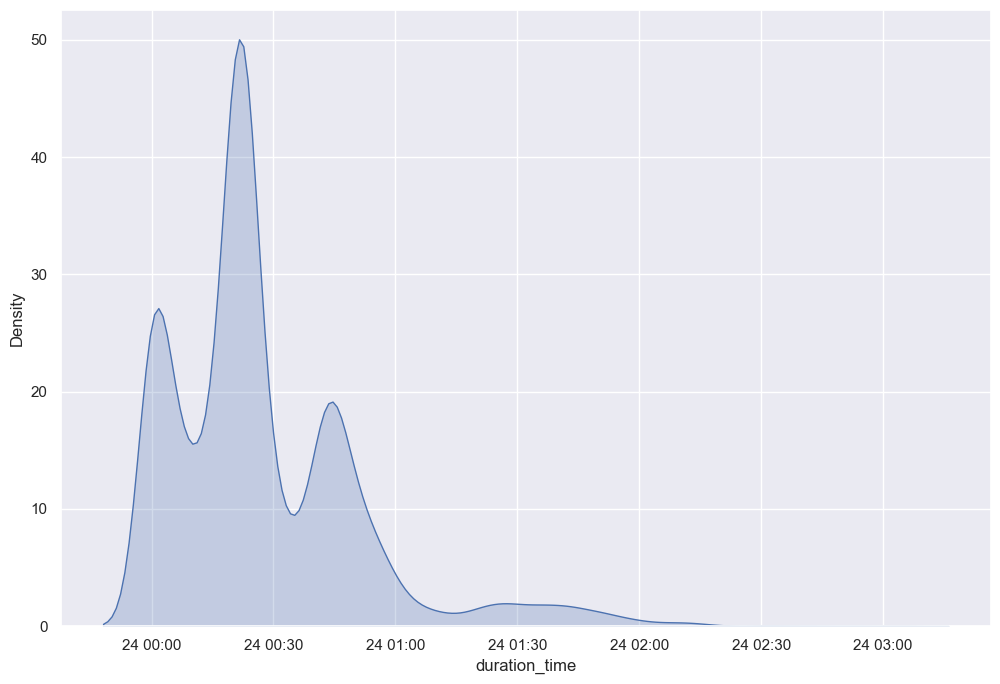

In [21]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,8))
ax=sns.kdeplot(data=df1["duration_time"], fill=True)

<AxesSubplot:xlabel='duration_time'>

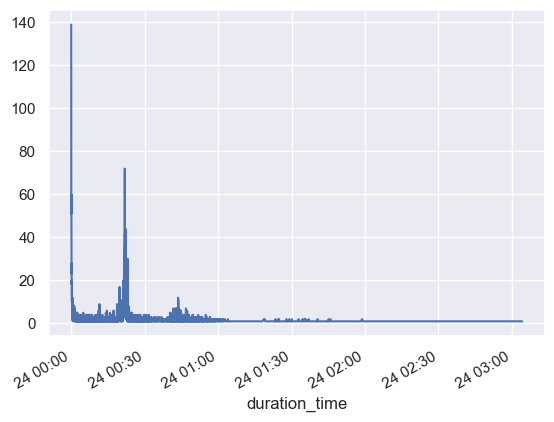

In [22]:
data = df1["duration_time"].groupby(pd.to_datetime(df1["duration_time"], infer_datetime_format=True)).agg("count")
data.plot()


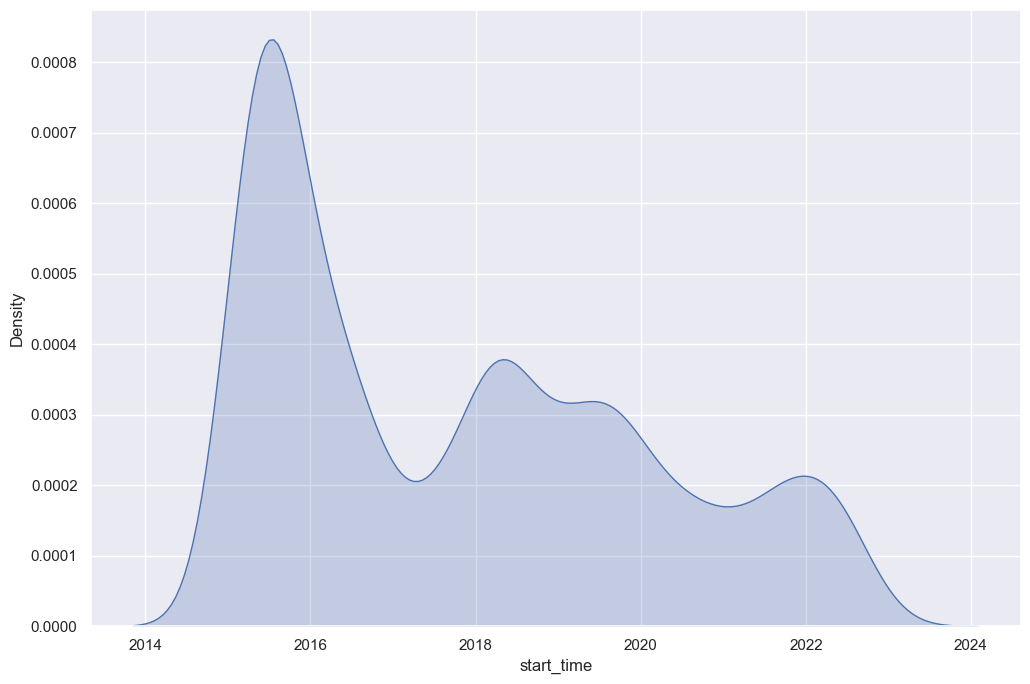

In [23]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,8))
ax=sns.kdeplot(data=df1['start_time'], fill=True)

<AxesSubplot:xlabel='start_time'>

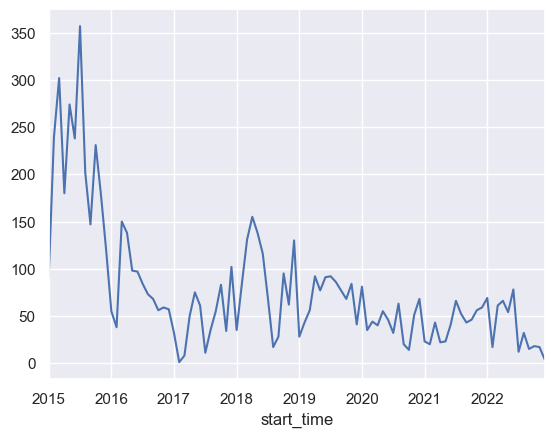

In [24]:
data = df1["start_time"].groupby(pd.to_datetime(df1["start_time"], infer_datetime_format=True).dt.to_period("M")).agg("count")
data.plot()


# 2.0 Feature Engineering

In [25]:
df2 = df1.copy()

In [26]:
# Lê se: vai ser serie se temporada  senao será filme
#criando nova coluna, para saber o que é filme e o que é serie
df2["categoria"]= df2["title"].apply( lambda x: "serie" if "Temporada" in x else "filme")


In [27]:
# ver se deu certo
df2[df2["categoria"]=="serie"]

,profile name,start time,duration,attributes,title,supplemental video type,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria
0,Kids,2022-08-27 17:08:40,2022-09-24 00:11:49,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,2022-09-24 00:11:49,00:11:49,BR (Brazil),2022-09-24 00:11:49,2022-08-27,serie
1,Kids,2022-08-27 17:05:32,2022-09-24 00:02:35,Autoplayed: user action: User_Interaction;,"Patrulha Canina: Temporada 6: Super filhotes, ...",NaN,Samsung 2014 MStar DTV,2022-09-24 00:12:17,00:12:17,BR (Brazil),2022-09-24 00:02:35,2022-08-27,serie
2,Kids,2022-08-27 16:53:22,2022-09-24 00:12:05,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,2022-09-24 00:12:09,00:12:09,BR (Brazil),2022-09-24 00:12:05,2022-08-27,serie
3,Kids,2022-08-27 16:30:08,2022-09-24 00:23:09,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,2022-09-24 00:23:09,00:23:09,BR (Brazil),2022-09-24 00:23:09,2022-08-27,serie
4,Kids,2022-08-27 16:26:38,2022-09-24 00:03:26,NaN,"Patrulha Canina: Temporada 6: Super filhotes, ...",NaN,Samsung 2014 MStar DTV,2022-09-24 00:03:26,00:03:26,BR (Brazil),2022-09-24 00:03:26,2022-08-27,serie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7454,Visitas,2015-04-26 20:30:42,2022-09-24 00:04:59,NaN,Friends: Temporada 6: Aquele em que Joey perde...,NaN,Samsung 2014 MStar DTV,2022-09-24 00:04:59,Not latest view,BR (Brazil),2022-09-24 00:04:59,2015-04-26,serie
7455,Visitas,2015-04-26 20:08:20,2022-09-24 00:21:54,NaN,Friends: Temporada 6: Aquele com a negação do ...,NaN,Samsung 2014 MStar DTV,2022-09-24 00:21:54,Not latest view,BR (Brazil),2022-09-24 00:21:54,2015-04-26,serie
7456,Visitas,2015-04-26 19:46:01,2022-09-24 00:21:53,NaN,Friends: Temporada 6: Aquele em que Ross abraç...,NaN,Samsung 2014 MStar DTV,2022-09-24 00:21:53,Not latest view,BR (Brazil),2022-09-24 00:21:53,2015-04-26,serie
7457,Visitas,2015-04-26 19:23:30,2022-09-24 00:22:06,NaN,Friends: Temporada 6: Aquele depois de Vegas (...,NaN,Samsung 2014 MStar DTV,2022-09-24 00:22:06,Not latest view,BR (Brazil),2022-09-24 00:22:06,2015-04-26,serie


In [28]:
df2[["title", "categoria"]]

,title,categoria
0,Patrulha Canina: Temporada 6: Os filhotes salv...,serie
1,"Patrulha Canina: Temporada 6: Super filhotes, ...",serie
2,Patrulha Canina: Temporada 6: Os filhotes salv...,serie
3,Patrulha Canina: Temporada 6: Os filhotes salv...,serie
4,"Patrulha Canina: Temporada 6: Super filhotes, ...",serie
...,...,...
7455,Friends: Temporada 6: Aquele com a negação do ...,serie
7456,Friends: Temporada 6: Aquele em que Ross abraç...,serie
7457,Friends: Temporada 6: Aquele depois de Vegas (...,serie
7458,Friends: Temporada 6: Aquele depois de Vegas (...,serie


# 3.0 Filtragem de Variáveis

In [79]:
df3 = df2.copy()

In [80]:
df3["supplemental video type"].unique()

array([nan, 'HOOK', 'TRAILER', 'RECAP', 'TEASER_TRAILER'], dtype=object)

In [81]:
# retirar profile kids
# retirar linhas com titulos trailler, hook, recap, teaser do dataset

df3.drop(df3.loc[df3["profile name"]=="Kids"].index, inplace=True)
df3.drop(df3.loc[df3["supplemental video type"]=="RECAP"].index, inplace=True)
df3.drop(df3.loc[df3["supplemental video type"]=="TRAILER"].index, inplace=True)
df3.drop(df3.loc[df3["supplemental video type"]=="HOOK"].index, inplace=True)
df3.drop(df3.loc[df3["supplemental video type"]=="TEASER_TRAILER"].index, inplace=True)


In [82]:
df3.loc[df3["categoria"]=="filme"].count()

profile name               1579
start time                 1579
duration                   1579
attributes                  519
title                      1579
supplemental video type       0
device type                1579
bookmark                   1579
latest bookmark            1579
country                    1579
duration_time              1579
start_time                 1579
categoria                  1579
dtype: int64

In [83]:
df3.loc[df3["categoria"]=="serie"].count()

profile name               5615
start time                 5615
duration                   5615
attributes                 1128
title                      5615
supplemental video type       0
device type                5615
bookmark                   5615
latest bookmark            5615
country                    5615
duration_time              5615
start_time                 5615
categoria                  5615
dtype: int64

In [84]:
1579 + 5615

7194

In [85]:
# sintaxe: df['column name'] = df['column name'].replace(['old value'],'new value')
df3["profile name"] = df3["profile name"].replace(["Visitas"],"Raquel")

In [86]:
df3['descricao']= df3['title'].str.extract('(:.?.+)', expand = True)
df3['descricao']

47                : Temporada 2: 2022-08-25 (Episódio 13)
48                : Temporada 2: 2022-08-18 (Episódio 12)
49                : Temporada 2: 2022-08-18 (Episódio 12)
52      : Temporada 1: Sonho de mil gatos/Calíope (Epi...
54                : Temporada 2: 2022-08-11 (Episódio 11)
                              ...                        
7455    : Temporada 6: Aquele com a negação do Ross (E...
7456    : Temporada 6: Aquele em que Ross abraça Rache...
7457    : Temporada 6: Aquele depois de Vegas (Episódi...
7458    : Temporada 6: Aquele depois de Vegas (Episódi...
7459                                                  NaN
Name: descricao, Length: 7194, dtype: object

In [87]:
# Deletar a descrição do title

df3["title"] = df3["title"].str.split(":", expand=True)[0]

In [88]:
# start stop and step variables
#start, stop, step = 1, 2, 1
  
# slicing till 2nd last element
#df3["descricao"] = df3["descricao"].str.slice(start, stop, step)


In [89]:
df3.head()

,profile name,start time,duration,attributes,title,supplemental video type,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria,descricao
47,Raquel,2022-09-04 22:06:00,2022-09-24 00:06:13,Autoplayed: user action: Unspecified;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-09-24 00:06:13,00:06:13,BR (Brazil),2022-09-24 00:06:13,2022-04-09,serie,: Temporada 2: 2022-08-25 (Episódio 13)
48,Raquel,2022-09-04 20:51:34,2022-09-24 00:46:54,NaN,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-09-24 01:14:17,01:14:17,BR (Brazil),2022-09-24 00:46:54,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12)
49,Raquel,2022-09-04 19:20:39,2022-09-24 00:27:26,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-09-24 00:27:26,Not latest view,BR (Brazil),2022-09-24 00:27:26,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12)
52,Raquel,2022-08-21 19:42:50,2022-09-24 00:32:01,NaN,Sandman,NaN,Samsung 2014 MStar DTV,2022-09-24 00:48:07,00:48:07,BR (Brazil),2022-09-24 00:32:01,2022-08-21,serie,: Temporada 1: Sonho de mil gatos/Calíope (Epi...
54,Raquel,2022-08-14 13:17:25,2022-09-24 01:12:09,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-09-24 01:12:09,01:12:09,BR (Brazil),2022-09-24 01:12:09,2022-08-14,serie,: Temporada 2: 2022-08-11 (Episódio 11)


In [90]:
df3.isna().sum()

profile name                  0
start time                    0
duration                      0
attributes                 5547
title                         0
supplemental video type    7194
device type                   0
bookmark                      0
latest bookmark               0
country                       0
duration_time                 0
start_time                    0
categoria                     0
descricao                   876
dtype: int64

In [91]:
df3["descricao"].fillna("-", inplace = True)

In [92]:
df3.drop_duplicates()

,profile name,start time,duration,attributes,title,supplemental video type,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria,descricao
47,Raquel,2022-09-04 22:06:00,2022-09-24 00:06:13,Autoplayed: user action: Unspecified;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-09-24 00:06:13,00:06:13,BR (Brazil),2022-09-24 00:06:13,2022-04-09,serie,: Temporada 2: 2022-08-25 (Episódio 13)
48,Raquel,2022-09-04 20:51:34,2022-09-24 00:46:54,NaN,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-09-24 01:14:17,01:14:17,BR (Brazil),2022-09-24 00:46:54,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12)
49,Raquel,2022-09-04 19:20:39,2022-09-24 00:27:26,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-09-24 00:27:26,Not latest view,BR (Brazil),2022-09-24 00:27:26,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12)
52,Raquel,2022-08-21 19:42:50,2022-09-24 00:32:01,NaN,Sandman,NaN,Samsung 2014 MStar DTV,2022-09-24 00:48:07,00:48:07,BR (Brazil),2022-09-24 00:32:01,2022-08-21,serie,: Temporada 1: Sonho de mil gatos/Calíope (Epi...
54,Raquel,2022-08-14 13:17:25,2022-09-24 01:12:09,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-09-24 01:12:09,01:12:09,BR (Brazil),2022-09-24 01:12:09,2022-08-14,serie,: Temporada 2: 2022-08-11 (Episódio 11)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,Raquel,2015-04-26 20:08:20,2022-09-24 00:21:54,NaN,Friends,NaN,Samsung 2014 MStar DTV,2022-09-24 00:21:54,Not latest view,BR (Brazil),2022-09-24 00:21:54,2015-04-26,serie,: Temporada 6: Aquele com a negação do Ross (E...
7456,Raquel,2015-04-26 19:46:01,2022-09-24 00:21:53,NaN,Friends,NaN,Samsung 2014 MStar DTV,2022-09-24 00:21:53,Not latest view,BR (Brazil),2022-09-24 00:21:53,2015-04-26,serie,: Temporada 6: Aquele em que Ross abraça Rache...
7457,Raquel,2015-04-26 19:23:30,2022-09-24 00:22:06,NaN,Friends,NaN,Samsung 2014 MStar DTV,2022-09-24 00:22:06,Not latest view,BR (Brazil),2022-09-24 00:22:06,2015-04-26,serie,: Temporada 6: Aquele depois de Vegas (Episódi...
7458,Raquel,2015-04-26 19:23:12,2022-09-24 00:00:09,NaN,Friends,NaN,Samsung 2014 MStar DTV,2022-09-24 00:00:09,Not latest view,BR (Brazil),2022-09-24 00:00:09,2015-04-26,serie,: Temporada 6: Aquele depois de Vegas (Episódi...


In [93]:
#df3.reset_index(drop=True, inplace=True)

In [94]:
#tirar duplicados na coluna title e juntar novamente ao dataframe
df3["title_2"] = df3["title"].drop_duplicates()

In [106]:
df3.head()

,profile name,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria,descricao,title_2
0,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:06:13,00:06:13,BR (Brazil),2022-09-24 00:06:13,2022-04-09,serie,: Temporada 2: 2022-08-25 (Episódio 13),Casais em Crise
1,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:48:07,00:48:07,BR (Brazil),2022-09-24 00:32:01,2022-08-21,serie,: Temporada 1: Sonho de mil gatos/Calíope (Epi...,Sandman
2,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:01:40,00:01:40,BR (Brazil),2022-09-24 00:01:40,2022-12-08,filme,-,1917
3,Raquel,Samsung 2014 MStar DTV,2022-09-24 01:38:05,01:38:05,BR (Brazil),2022-09-24 01:39:13,2022-08-08,filme,-,Spiderhead
4,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:00:02,00:00:02,BR (Brazil),2022-09-24 00:00:02,2022-08-08,serie,: Temporada 1: Degenerado (Episódio 1),Cobra Kai


In [96]:
df3.drop(["title"], axis=1, inplace=True)

In [97]:
df3.isna().sum()

profile name                  0
start time                    0
duration                      0
attributes                 5547
supplemental video type    7194
device type                   0
bookmark                      0
latest bookmark               0
country                       0
duration_time                 0
start_time                    0
categoria                     0
descricao                     0
title_2                    6428
dtype: int64

In [105]:
df3.reset_index(drop=True, inplace=True)

In [100]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   profile name             7194 non-null   object        
 1   start time               7194 non-null   datetime64[ns]
 2   duration                 7194 non-null   datetime64[ns]
 3   attributes               1647 non-null   object        
 4   supplemental video type  0 non-null      object        
 5   device type              7194 non-null   object        
 6   bookmark                 7194 non-null   datetime64[ns]
 7   latest bookmark          7194 non-null   object        
 8   country                  7194 non-null   object        
 9   duration_time            7194 non-null   datetime64[ns]
 10  start_time               7194 non-null   datetime64[ns]
 11  categoria                7194 non-null   object        
 12  descricao                7194 non-

In [101]:
df3.loc[df3["descricao"]=="-"].count()

profile name               876
start time                 876
duration                   876
attributes                 251
supplemental video type      0
device type                876
bookmark                   876
latest bookmark            876
country                    876
duration_time              876
start_time                 876
categoria                  876
descricao                  876
title_2                    476
dtype: int64

## 3.1 Seleção das colunas

In [102]:
df3.drop(["start time", "duration", "attributes", "supplemental video type"], axis=1, inplace=True)


In [103]:
df3.dropna (axis = 0, inplace = True)

# 4.0 EDA - Análise Exploratória dos Dados

In [107]:
df4 = df3.copy()

Text(0.5, 1.0, 'Palavras mais populares na descrição da Netflix')

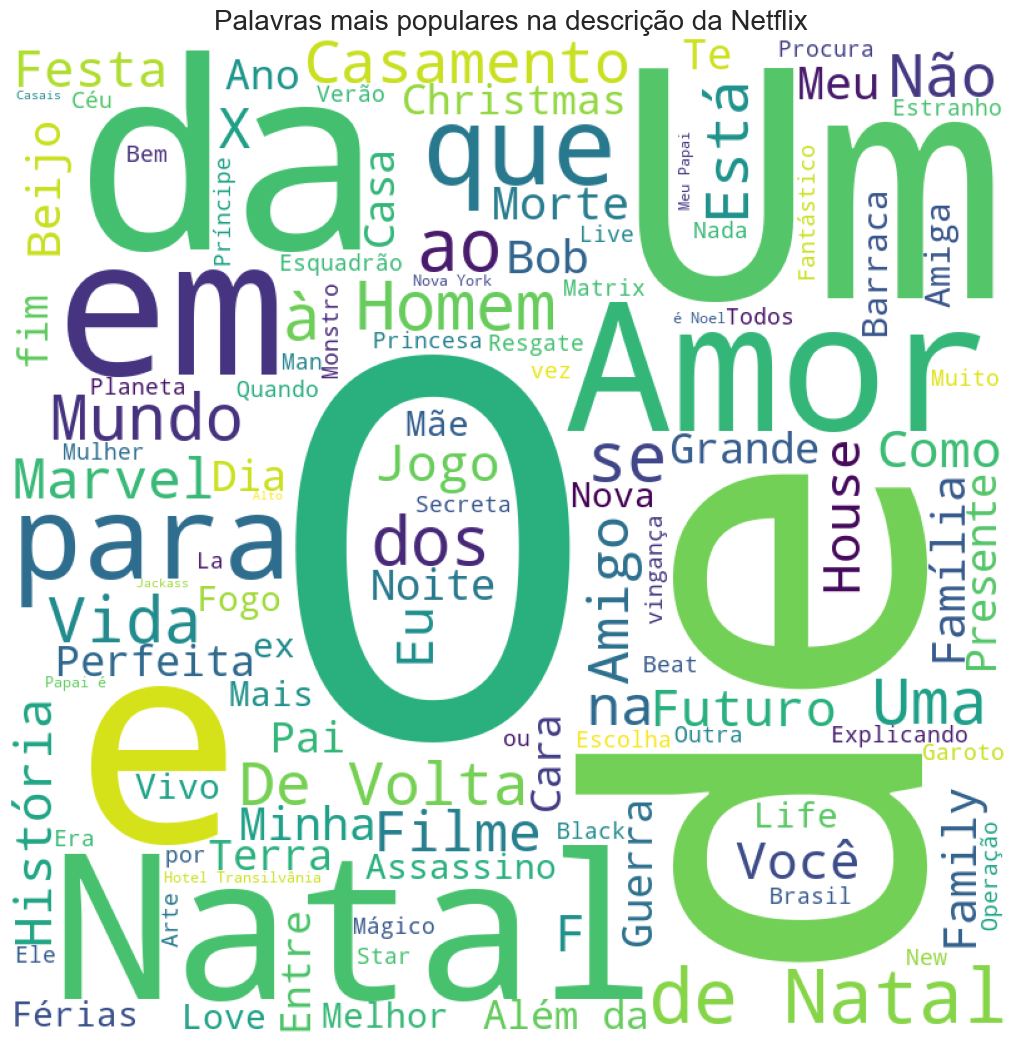

In [108]:
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color = 'white', width = 800,  height = 800, max_words = 121).generate(' '.join(map(str,df4['title_2'])))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Palavras mais populares na descrição da Netflix',fontsize = 20)


## 4.1 Categorical Attributes

In [109]:
def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )  

def cramers_v_df(categorical_features):

    rows= []

    for var1 in categorical_features:

        col = []

        for var2 in categorical_features:
            cramers =cramer_v(categorical_features[var1], categorical_features[var2]) 
            col.append(round(cramers,3)) 

        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns=categorical_features.columns, index=categorical_features.columns)

    return df

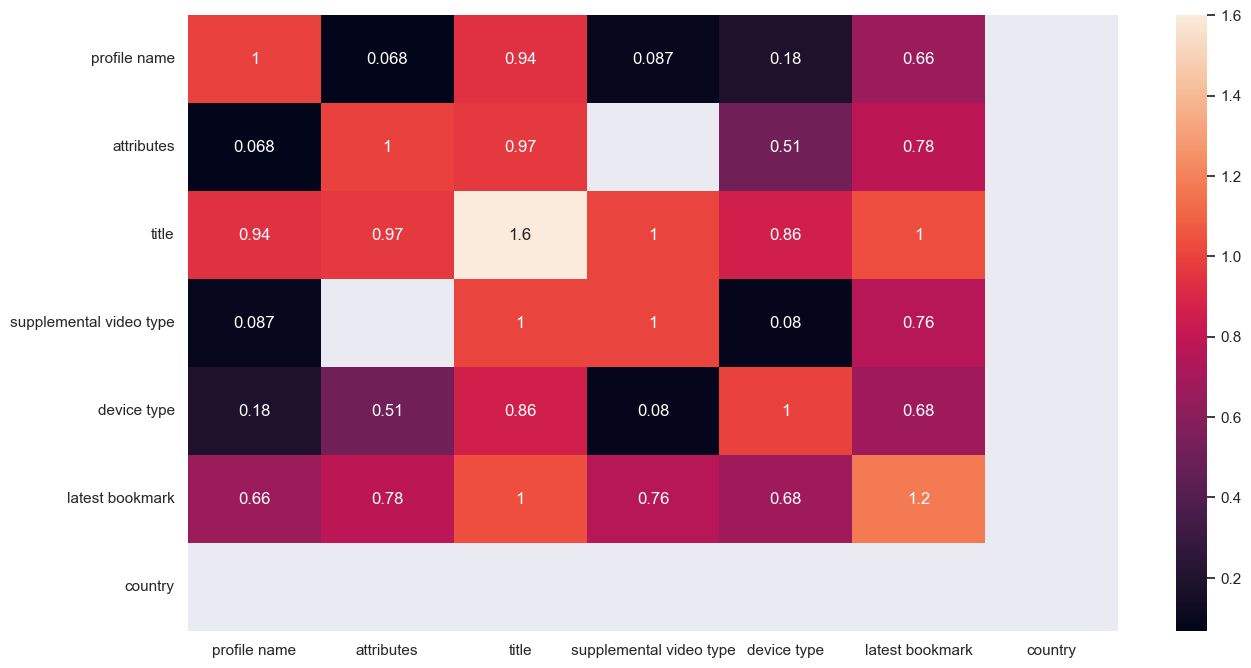

In [110]:
cat_features = cat_attributes

# dataframe with cramer-v 
cramer_v_dataframe = cramers_v_df(cat_features)

# create a mask
mask = np.zeros_like(cramer_v_dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# display heatmap
plt.subplots(figsize=(15, 8))
sns.heatmap( cramer_v_dataframe, annot = True);

#esse abaixo muda o formato do gráfico de correlação
#sns.heatmap( cramer_v_dataframe, annot = True, mask=mask);

# 5.0 Data Preparation

In [111]:
df5 = df4.copy()

# 6.0 Feature Selection

In [112]:
df6 = df5.copy()

# 7.0 Machine Learning Modelling

## 7.1 TfidfVectorizer - Score

In [111]:
TfidfVectorizer

sklearn.feature_extraction.text.TfidfVectorizer

## Content Based Recommender

In [113]:
df6

,profile name,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria,descricao,title_2
0,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:06:13,00:06:13,BR (Brazil),2022-09-24 00:06:13,2022-04-09,serie,: Temporada 2: 2022-08-25 (Episódio 13),Casais em Crise
1,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:48:07,00:48:07,BR (Brazil),2022-09-24 00:32:01,2022-08-21,serie,: Temporada 1: Sonho de mil gatos/Calíope (Epi...,Sandman
2,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:01:40,00:01:40,BR (Brazil),2022-09-24 00:01:40,2022-12-08,filme,-,1917
3,Raquel,Samsung 2014 MStar DTV,2022-09-24 01:38:05,01:38:05,BR (Brazil),2022-09-24 01:39:13,2022-08-08,filme,-,Spiderhead
4,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:00:02,00:00:02,BR (Brazil),2022-09-24 00:00:02,2022-08-08,serie,: Temporada 1: Degenerado (Episódio 1),Cobra Kai
...,...,...,...,...,...,...,...,...,...,...
761,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:54:13,00:54:13,BR (Brazil),2022-09-24 00:27:55,2015-08-05,serie,: Temporada 1: Celeste e primal (Episódio 10),Marco Polo
762,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:19:55,00:19:55,BR (Brazil),2022-09-24 00:19:55,2015-06-05,filme,: Fora do Normal,Fábio Porchat
763,Raquel,Samsung 2014 MStar DTV,2022-09-24 01:30:36,01:30:36,BR (Brazil),2022-09-24 01:36:09,2015-03-05,filme,-,Será Que?
764,Raquel,Samsung 2014 MStar DTV,2022-09-24 00:04:16,00:04:16,BR (Brazil),2022-09-24 00:04:16,2015-04-28,serie,: Temporada 1: Os primeiros passos (Episódio 1),Life Story


In [114]:
dados_modelo = df6[["title_2","descricao"]]
dados_modelo.head()

,title_2,descricao
0,Casais em Crise,: Temporada 2: 2022-08-25 (Episódio 13)
1,Sandman,: Temporada 1: Sonho de mil gatos/Calíope (Epi...
2,1917,-
3,Spiderhead,-
4,Cobra Kai,: Temporada 1: Degenerado (Episódio 1)


In [115]:
tfidf = TfidfVectorizer(stop_words="english")

In [116]:
#!pip3 install nltk
#import nltk
#nltk.download('stopwords')

In [117]:
#stopwords.words("english")

In [118]:
tfidf_matrix = tfidf.fit_transform(df6["descricao"])

In [119]:
tfidf_matrix.shape

(766, 615)

In [120]:
#print("Palavras extraídas",tfidf.get_feature_names())

In [121]:
# Matriz esparsa
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names(), index=df6.title_2).sample(10, axis=1).sample(20, axis=0)


,neandertal,desventuras,amoroso,abigail,fiasco,patos,white,degenerado,tale,anarquia
title_2,,,,,,,,,,
Dumplin',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orange Is the New Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steve Jobs - O Homem e a Máquina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Masha e o Urso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Luther,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Explicando... Dinheiro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
De Volta para o Futuro II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American Pie – O Livro do Amor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Recursos Humanos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

In [123]:
cosine_sim[0]

array([1.        , 0.05202276, 0.        , 0.        , 0.10372666,
       0.        , 0.10372666, 0.08333591, 0.07086124, 0.02173195,
       0.        , 0.        , 0.04506728, 0.07898149, 0.        ,
       0.        , 0.        , 0.07694308, 0.03106477, 0.04091745,
       0.        , 0.31417042, 0.04680106, 0.        , 0.        ,
       0.22962426, 0.07694308, 0.04378712, 0.        , 0.        ,
       0.        , 0.        , 0.06378441, 0.08403859, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.22962426, 0.07694308, 0.10491862, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02667864,
       0.        , 0.        , 0.        , 0.        , 0.02305653,
       0.        , 0.        , 0.        , 0.        , 0.01735448,
       0.10372666, 0.        , 0.        , 0.        , 0.        ,
       0.07086124, 0.        , 0.07136346, 0.05659181, 0.        ,
       0.        , 0.07694308, 0.05578091, 0.07161738, 0.     

In [124]:
# cálculo das similaridades
cosine_sim_df = pd.DataFrame(cosine_sim, index=df6["title_2"], columns=df6["title_2"])
print("shape",cosine_sim_df.shape)
cosine_sim_df.sample(40, axis=1).round(2)

shape (766, 766)


title_2,Dou-lhes um Ano,"Amor, Felicidade ou Casamento",Um Brinde ao Natal,Namorado de Natal,Procurando Dory,A Escolha,Battle for Haditha,Miss Me This Christmas,Klaus,A Incrível História da Ilha das Rosas,...,"Coragem, o Cão Covarde",Life Story,Family Guy,Como Cães e Gatos 2 – A Vingança de Kitty Galore,O Mundo Segundo os Brasileiros,Tony Robbins,Elisa y Marcela,Pense como eles,I Am Mother,Company of Heroes - O Filme
title_2,,,,,,,,,,,,,,,,,,,,,
Casais em Crise,0.0,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04,0.07,0.06,0.0,0.08,0.0,0.0,0.0,0.0,0.0
Sandman,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04,0.06,0.05,0.0,0.07,0.0,0.0,0.0,0.0,0.0
1917,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
Spiderhead,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
Cobra Kai,0.0,0.0,0.0,0.12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.07,0.12,0.11,0.0,0.14,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Marco Polo,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.05,0.08,0.07,0.0,0.09,0.0,0.0,0.0,0.0,0.0
Fábio Porchat,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
Será Que?,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [125]:
indices = pd.Series(df6.index, index = df6["title_2"]).drop_duplicates()


In [126]:
indices

title_2
Casais em Crise                        0
Sandman                                1
1917                                   2
Spiderhead                             3
Cobra Kai                              4
                                    ... 
Marco Polo                           761
Fábio Porchat                        762
Será Que?                            763
Life Story                           764
As aventuras de Peabody e Sherman    765
Length: 766, dtype: int64

In [127]:
indicesp = indices['Atleta A']
type(indicesp)

numpy.int64

In [128]:
indicesp = indices['Brincando com Fogo']
type(indicesp)

numpy.int64

In [129]:
# Function that takes in movie title as input and outputs most similar movies
# indices = indice do titulo de filmes
def get_recommendations(title, cosine_sim=cosine_sim):
    
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return dados_modelo["title_2"].iloc[movie_indices]

In [130]:
df6["title_2"][370]

'Peaky Blinders'

In [132]:
# Teste
get_recommendations('Peaky Blinders')


413                                   3%
25                      Back with the Ex
41     Solteiros, Ilhados e Desesperados
278         The End of the F***ing World
387              Três Esposas, Um Marido
443                       A Louva-a-deus
453                               Luther
656                    The Witches of Oz
389                    Wild Wild Country
75                            Ponto Cego
Name: title_2, dtype: object

In [133]:
# Recomendação com o Score

def get_recommendations(title, cosine_sim = cosine_sim):

    idx = indices[title]
    sim_scores = enumerate(cosine_sim[idx])
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    for i in sim_scores:
        print(i)
    movie_indices = [i[0] for i in sim_scores]
    print()
    print(dados_modelo["title_2"].iloc[movie_indices])
    
get_recommendations('Peaky Blinders')


(413, 0.24562952790916717)
(25, 0.1809185420380791)
(41, 0.1809185420380791)
(278, 0.1809185420380791)
(387, 0.1809185420380791)
(443, 0.1809185420380791)
(453, 0.1809185420380791)
(656, 0.1809185420380791)
(389, 0.11039034075193045)
(75, 0.10387598593714795)

413                                   3%
25                      Back with the Ex
41     Solteiros, Ilhados e Desesperados
278         The End of the F***ing World
387              Três Esposas, Um Marido
443                       A Louva-a-deus
453                               Luther
656                    The Witches of Oz
389                    Wild Wild Country
75                            Ponto Cego
Name: title_2, dtype: object


# 8.0 Hypermarameter Fine Tunning

# 9.0 Deploy